# Human Long Promoter Classification with Genomic Pretraining and Fine Tuning (4mer)

This notebook adds a fine tuning step to the long promoter classification model. For more detail about the fine tuning process, see the [Human 4 Short Promoter Classification with Fine Tuning](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Mammals/Human/Human%204%20Short%20Promoter%20Classification%20with%20Fine%20Tuning.ipynb) notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')
path_mam = Path('F:/genome/mammals/')

# LM Fine Tune

In [5]:
classification_df = pd.read_csv(path/'human_promoters_long.csv')

In [6]:
classification_df.head()

,Sequence,Target,set
0,ccaGTTGAAAAGTAGAGGCCGAGGACAGAGTTAGACACTCGTTGTC...,1,train
1,ggaagggcgCAAGAGAGGATCAGGGGTCAGCGGCACACCCATGGAG...,1,train
2,TAAAGAAATACAAGGATTCCTCAAGCCCCTCTTCCCTAAAACATGC...,1,train
3,CGCGGGGCCGGGGAAGCCCGCGCGCGTCATCAGCAGCGGCGCCGCG...,1,train
4,TACACAGTAAGGACAGCCGCTGGAGCGCTACGGTCTGACGAACGAG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((56834, 3), (6316, 3), (7017, 3))

In [9]:
voc = np.load(path/'human_vocab_8mer.npy')
model_vocab = GenomicVocab(voc)

In [10]:
len(model_vocab.itos)

65537

In [11]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=8, stride=3), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=90, tokenizer=tok, bptt=70,
                              chunksize=10000, text_cols='Sequence', label_cols='Target', vocab=model_vocab)

In [15]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25,
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [16]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [17]:
learn.load('human_large2');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


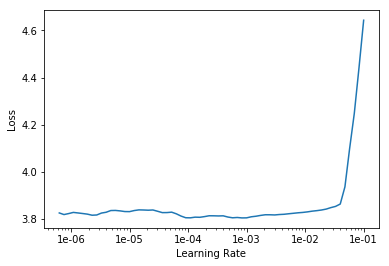

In [27]:
learn.recorder.plot(skip_end=20)

In [28]:
learn.fit_one_cycle(4, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.752999,3.677558,0.134628,13:20
1,3.705404,3.672204,0.135441,13:21
2,3.631518,3.644305,0.139996,13:22
3,3.560684,3.637117,0.141616,13:25


In [29]:
learn.save('human_8mer_longprom_finetune')
learn.save_encoder('human_8mer_longprom_finetune_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'human_promoters_long.csv')

In [6]:
classification_df.head()

,Sequence,Target,set
0,ccaGTTGAAAAGTAGAGGCCGAGGACAGAGTTAGACACTCGTTGTC...,1,train
1,ggaagggcgCAAGAGAGGATCAGGGGTCAGCGGCACACCCATGGAG...,1,train
2,TAAAGAAATACAAGGATTCCTCAAGCCCCTCTTCCCTAAAACATGC...,1,train
3,CGCGGGGCCGGGGAAGCCCGCGCGCGTCATCAGCAGCGGCGCCGCG...,1,train
4,TACACAGTAAGGACAGCCGCTGGAGCGCTACGGTCTGACGAACGAG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((56834, 3), (6316, 3), (7017, 3))

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=8, stride=3), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [10]:
voc = np.load(path/'human_vocab_8mer.npy')
model_vocab = GenomicVocab(voc)

In [11]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Target', bs=180)

In [12]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(65537, 65537)

In [15]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [16]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [17]:
learn = learn.to_fp16(dynamic=True);

In [18]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(65537, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(65537, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.16000000000000003)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=

In [19]:
learn.load_encoder('human_8mer_longprom_finetune_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


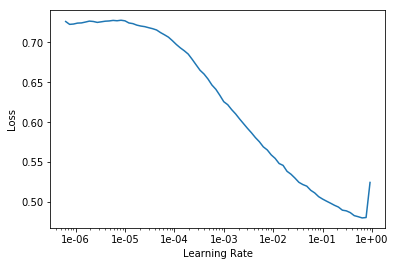

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(2, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.343822,0.316003,0.861463,02:11
1,0.328800,0.312582,0.864313,02:12


In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.331926,0.327867,0.856555,02:39
1,0.296391,0.297720,0.873021,02:39
2,0.279163,0.289733,0.875871,02:40


In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.273705,0.302347,0.870804,03:50
1,0.276321,0.287736,0.876346,03:48
2,0.249699,0.301793,0.874604,03:49


In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.241828,0.305030,0.874446,04:46
1,0.235915,0.305601,0.875712,04:47
2,0.228788,0.309558,0.874921,04:48


In [25]:
learn.save('human_long_8mer_finetune_clas')

In [26]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Target', bs=100)
learn.data = data_clas

In [27]:
get_scores(learn)

Accuracy: 0.8745902807467578
False Positives: 0.0420407581587573
False Negatives: 0.08336896109448483
Recall: 0.8023648648648649
Precision: 0.8895131086142322
Specificity: 0.9272861720483115
MCC: 0.742186606132758
